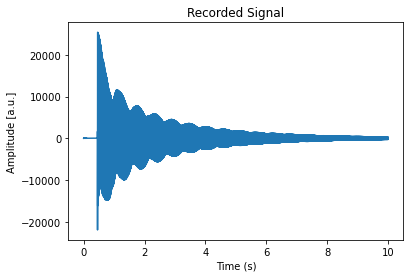

In [2]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import peakutils
from peakutils.plot import plot as pplot
from scipy.optimize import curve_fit
from numpy import pi,sqrt,arctan,tan

#%matplotlib tk
Tk().withdraw()
filename = askopenfilename() #open file dialog

# read audio samples
input_data = read(filename)
signal = input_data[1]
sampling_freq = input_data[0]
time = np.arange(len(signal))/sampling_freq

def plot_data(start_time,end_time):
	#function to plot data between start_time and end_time

	time_index1 = time.tolist().index(start_time)
	time_index2 = time.tolist().index(end_time)
	plt.figure()
	plt.plot(time[time_index1:time_index2+1],signal[time_index1:time_index2+1])
	plt.ylabel("Amplitude [a.u.]")
	plt.xlabel("Time (s)")
	plt.title("Recorded Signal")
	plt.show()

def FT_data(data,sampling_rate):
 #function to calculate and display absolute value of Fourier Transform

	freq = 0.5 * sampling_rate * np.linspace(-1.0, 1.0, len(data))
	FTdata = np.fft.fftshift(np.fft.fft(np.fft.fftshift(data)))

	freq_index1 = np.amin(np.where(freq >= 0))
	freq_index2 = np.amin(np.where(freq >= 3000))
	# plt.figure()
	# plt.plot(freq[freq_index1:freq_index2+1],abs(FTdata[freq_index1:freq_index2+1]))
	# plt.ylabel("Magnitude [a.u.]")
	# plt.xlabel("Frequency (Hz)")
	# plt.title("Absolute Value of Fourier Transform")
	# plt.show()
    
	return freq[freq_index1:freq_index2+1],abs(FTdata[freq_index1:freq_index2+1])



plot_data(0,10) #plot signal in time window defined by 2 values
freq, magn = FT_data(signal,sampling_freq) #Fourier Transform and plot absolute value
FFT_df = pd.DataFrame(np.vstack((freq, magn)).T, columns=['Frequency', 'Magnitude [a.u.]'])

In [59]:
def resonance_func(w,w0,N,v,b):
	resonance_curve = N/(sqrt(((w)**2-w0**2)**2+(v*(w))**2))+b
	return resonance_curve

def find_resn(signal, sampling_freq, plot_graph = False):
	#filename = askopenfilename() 
	FT_freq, magn = FT_data(signal,sampling_freq)

	indexes = peakutils.indexes(magn, thres=0.005, min_dist=2000)
	peaks = np.vstack((freq[indexes],magn[indexes])).T 
	
	freq_peaks_int = peakutils.interpolate(FT_freq, magn, ind=indexes) #interpolated

	if plot_graph == True:
		plt.figure(figsize=(10,6))
		pplot(freq, magn, indexes)
		plt.title('First estimate')
		plt.show()
	#print(peaks)
	#print(freq_peaks_int)
	
	return [peaks, freq_peaks_int]
	
	'''
	resn_magn = []
	for m in magn:
			if m > 
	initial_guess=[143,5e9,1,100000] 
	po,po_cov=curve_fit(resonance_func,FT_freq,magn,initial_guess)
	plt.figure()
	plt.plot(FT_freq,magn)
	plt.plot(FT_freq,resonance_func(FT_freq,po[0],po[1],po[2],po[3]))
	print('f0 = %.3e +/- %.3e Hz' %(po[0],sqrt(po_cov[0,0])))
	print('N =  %.3e +/- %.3e' %(po[1],sqrt(po_cov[1,1])))
	print('v = %.3e +/- %.3e' %(po[2],sqrt(po_cov[2,2])))
	print('b = %.3e +/- %.3e' %(po[3],sqrt(po_cov[3,3])))
	'''

In [4]:
def tophat(start, end, end_of_graph, density):
    ini_plot_x = np.linspace(0, end_of_graph, density)
    y = [0] * len(ini_plot_x)
    for idx, x in enumerate(ini_plot_x):
        if x >= start and x <= end:
          y[idx] = 1

    return ini_plot_x, y

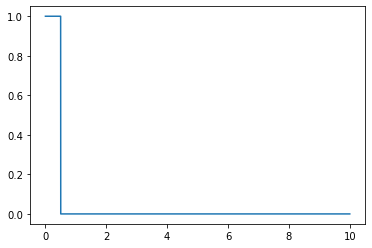

In [5]:
top_x, top_y = tophat(0,0.5,10,len(signal))
plt.plot(top_x,top_y)

(array([0.00000000e+00, 3.16592915e-02, 6.33185829e-02, ...,
        2.99993948e+03, 2.99997114e+03, 3.00000280e+03]),
 array([ 43753.        ,  47448.07377243,  56969.99869794, ...,
        108108.94470413, 106721.97105797, 105918.98602511]))

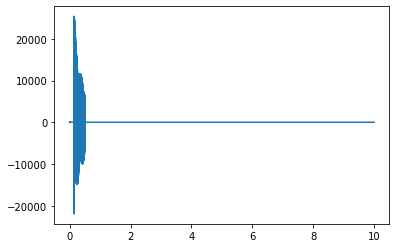

In [6]:
func_prod = top_y * signal
plt.plot(top_x,func_prod)
FT_data(func_prod,sampling_freq)

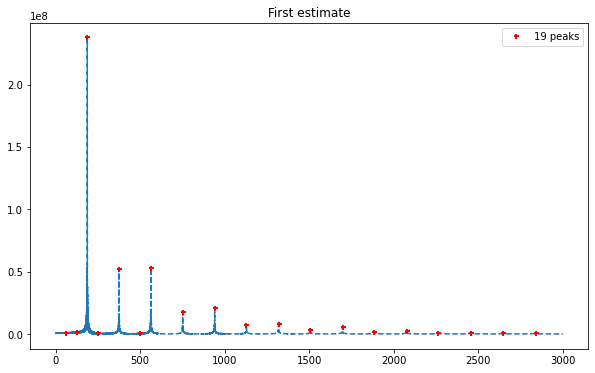

1008443.0416594709
1542686.9458890564
237784960.86246228
662058.9977411452
52266974.750634335
445464.8615082897
52904598.10614312
17241459.15885302
20522152.3883499
7582550.089198725
7918541.097423694
2841786.378164424
5813606.467488948
1918387.402403526
2274613.911183318
839181.6470659556
1167412.5481856214
469320.6113342894
455360.1233309725


In [7]:
resn, freq_resi = find_resn(func_prod,sampling_freq)
for i in resn:
  print(i[1])

In [8]:
print(freq_resi)

[  59.7203205   123.85274427  187.51396025  251.15057548  375.0050907
  500.71065817  564.37251074  751.87268472  941.16461187 1128.64843911
 1318.63126315 1506.15164956 1697.06301487 1884.64113534 2075.89360669
 2263.62781474 2457.75953667 2645.59335913 2840.46617151]


In [70]:
def find_pluck_time(signal,time):
  # function to find the plucking time and index
  
  time_limit_index = np.amin(np.where(time >= 0.1))
  avg_signal = np.average(signal[0: time_limit_index])
  std_signal = np.std(signal[0:time_limit_index])
  
  pluck_index = np.amin(np.where(signal >= (avg_signal+3.5*std_signal)))
  pluck_time = time[pluck_index]
  
  return pluck_time, pluck_index

# finding the decay function

In [ ]:
filename_2 = askopenfilename()
input_data_decay = read(filename_2)

In [88]:
from xml.sax.handler import feature_string_interning



def find_decay(input_data, left_range = 150, right_range = 225, time_interval = 0.5, plot_graph = False):
  signal = input_data[1]
  sampling_freq = input_data[0]
  amp_list = []
  freq_list = []

  for i in np.arange(0, 10, time_interval):
    top_x, top_y = tophat(i, i + time_interval, 10, len(signal))
    func_prod = top_y * signal
    resn, freq_resi = find_resn(func_prod,sampling_freq, plot_graph)
    
    for x in resn:
      if x[0] < right_range and x[0] > left_range:
        amp_list.append(x[1])
        freq_list.append(x[0])


  time_list = plot_decay(amp_list, time_interval, amp_list, left_range, right_range)
  # plt.plot(amp_list)
  # plt.show()
  plt.plot(freq_list)
  plt.ylabel("Frequency [Hz]")
  plt.xlabel("Measured value")
  plt.title("Frequency range for decay plot (" + str(left_range) + "Hz to " + str(right_range) + "Hz with time interval " + str(time_interval) + "s)", pad = 20.0)
  plt.show()
  return amp_list, freq_list, np.array(time_list)

def plot_decay(amplitude, time_interval, amp_list, left_range, right_range):
  time = []
  for i in np.arange(0, 10, time_interval):
    time.append(i)
  plt.plot(time[:len(amp_list)], amplitude)
  plt.title("Decay curve of Frequency range " + str(left_range) + "Hz to " + str(right_range) + "Hz with time interval " + str(time_interval) + "s", pad = 20.0)
  plt.ylabel("Amplitude [a.u.]")
  plt.xlabel("Time (s)")
  #plt.tight_layout()
  plt.show()
  return time[:len(amp_list)]

#amp_list, freq_list = find_decay(input_data_decay)

#print(amp_list)



    


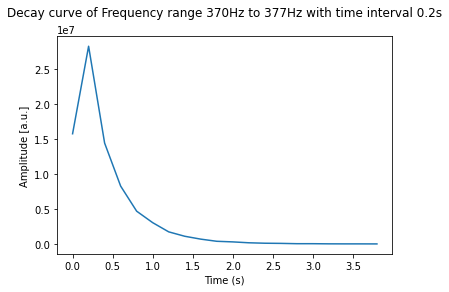

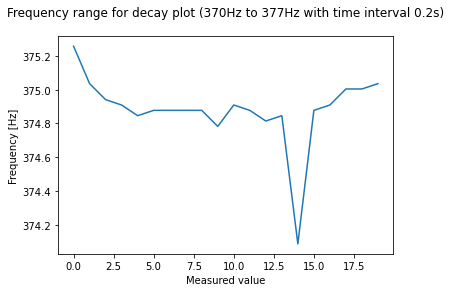

([15764539.822324246,
  28284439.72941042,
  14431402.735767212,
  8280705.031949362,
  4689328.5493768165,
  3048051.397252997,
  1732553.1195429303,
  1103047.1047033493,
  691640.072767761,
  383313.6569449153,
  296818.2710170823,
  169332.41128210328,
  106066.9746933017,
  83488.877371776,
  38753.936717285345,
  38274.42220508281,
  18462.32344221588,
  12809.043661032205,
  12555.495524008318,
  7119.889747615302],
 [375.25758171830097,
  375.0359666780556,
  374.94098880366613,
  374.9093295122046,
  374.84601092927664,
  374.8776702207382,
  374.8776702207382,
  374.8776702207382,
  374.8776702207382,
  374.7826923463487,
  374.9093295122046,
  374.8776702207382,
  374.8143516378102,
  374.84601092927664,
  374.0861879341461,
  374.8776702207382,
  374.9093295122046,
  375.00430738659406,
  375.00430738659406,
  375.0359666780556])

In [57]:
find_decay(input_data_decay,370,377,0.2)

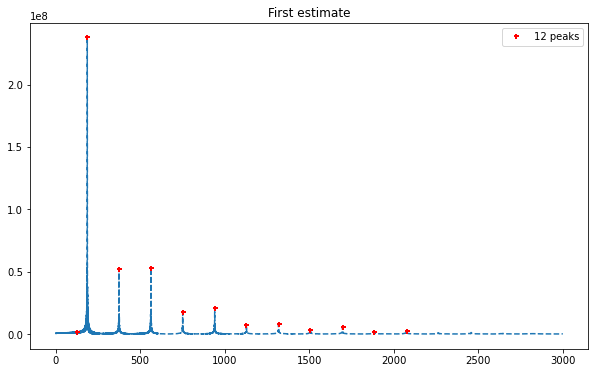

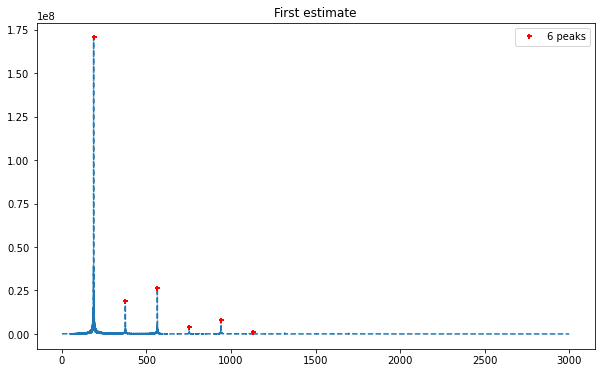

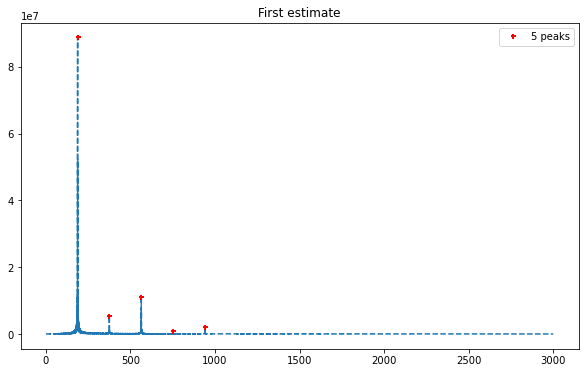

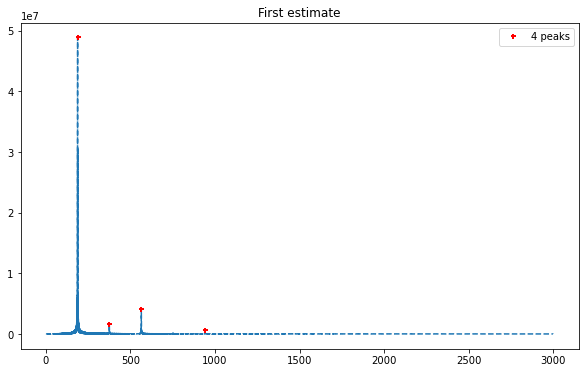

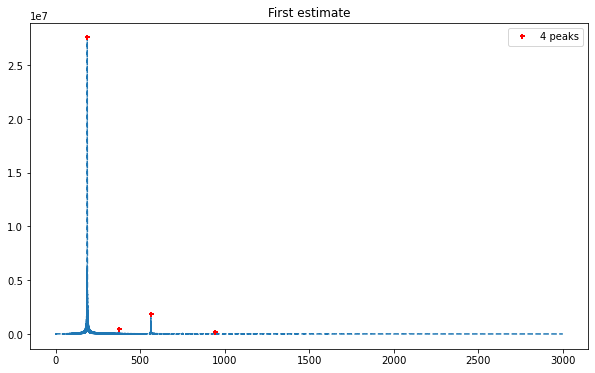

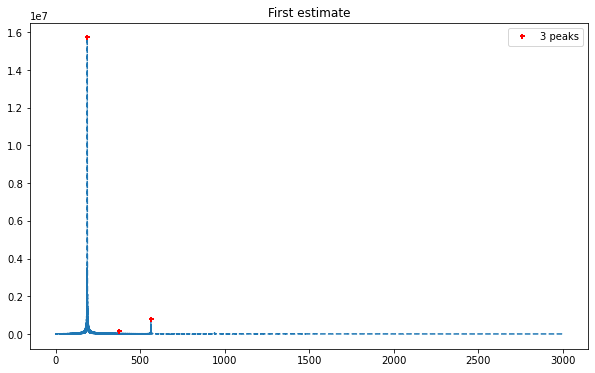

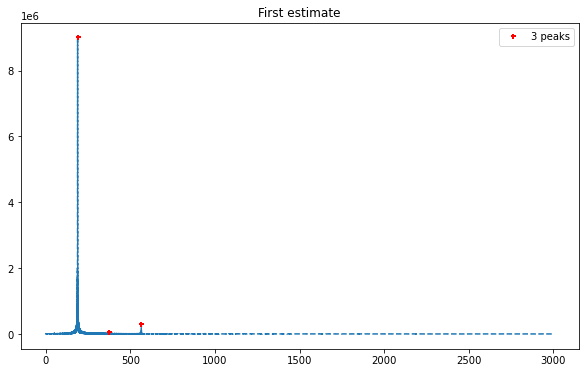

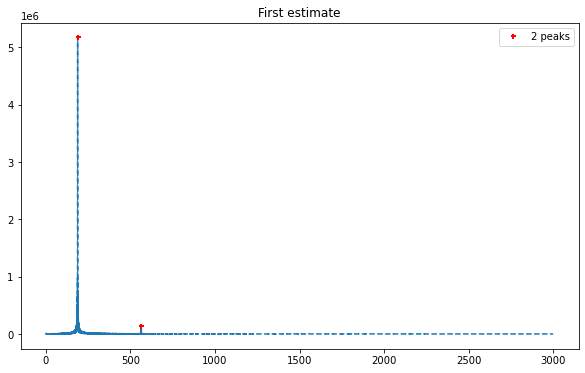

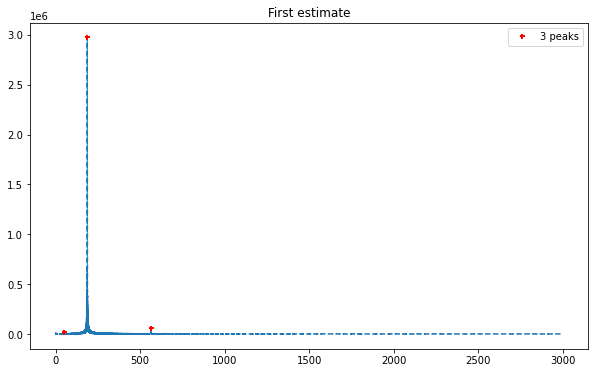

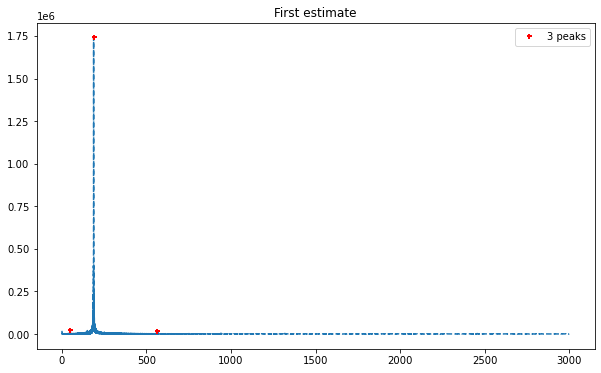

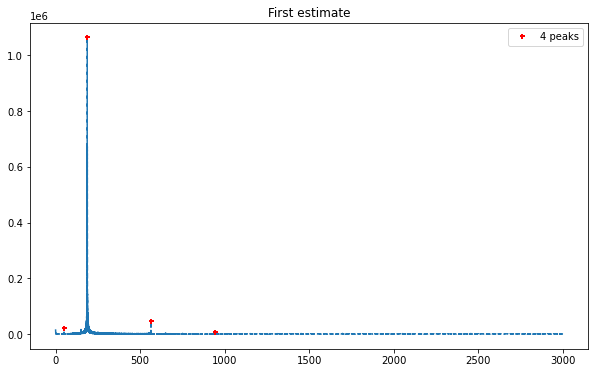

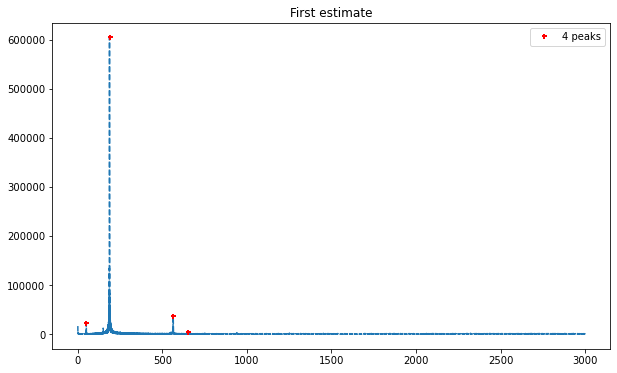

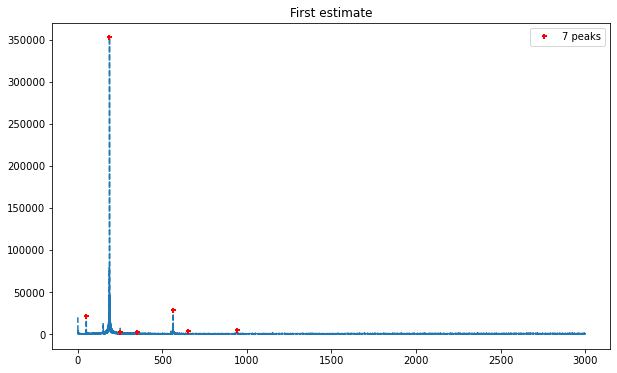

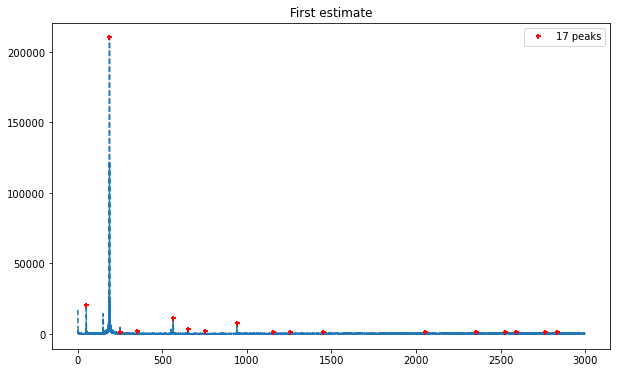

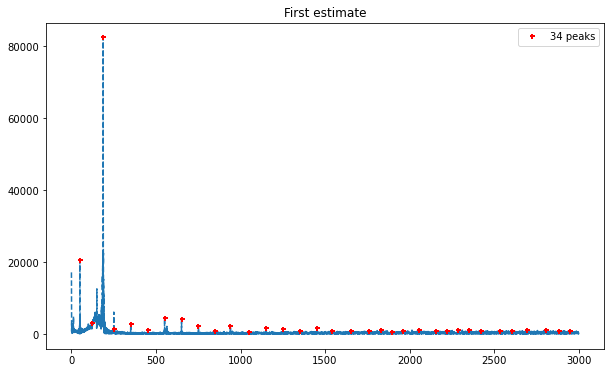

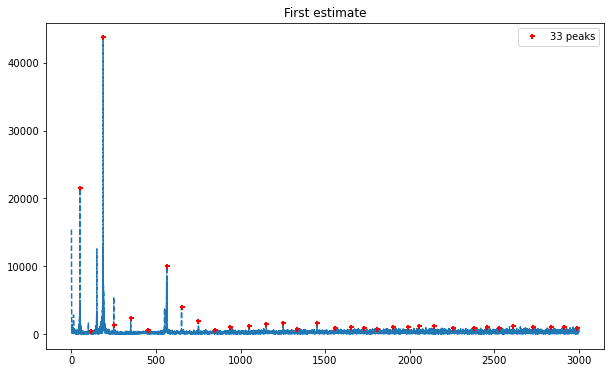

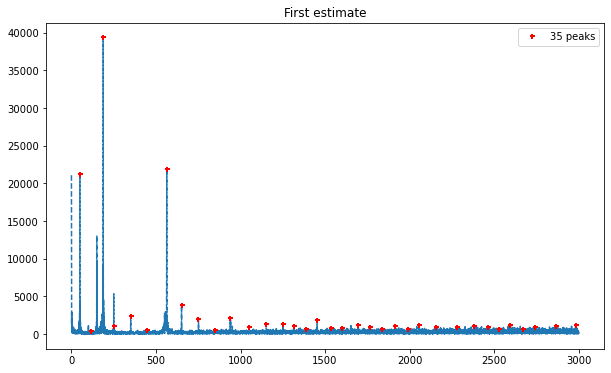

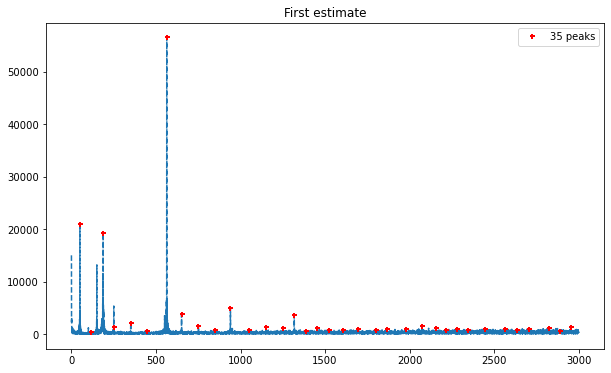

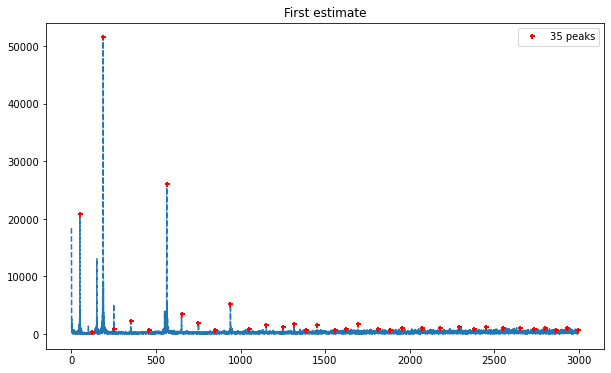

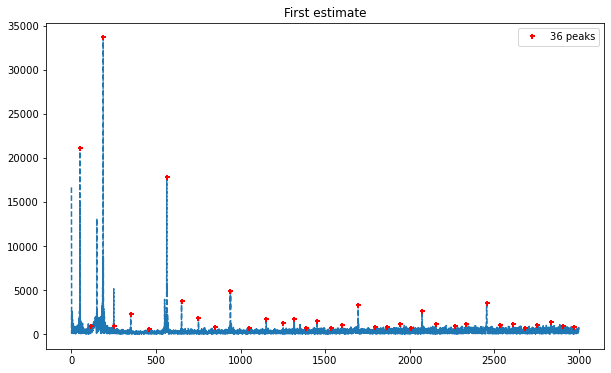

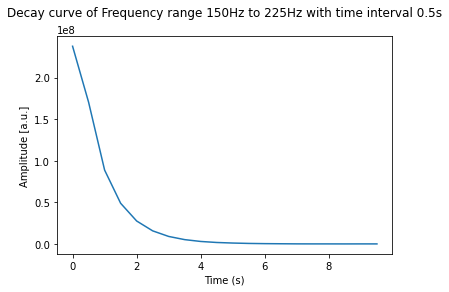

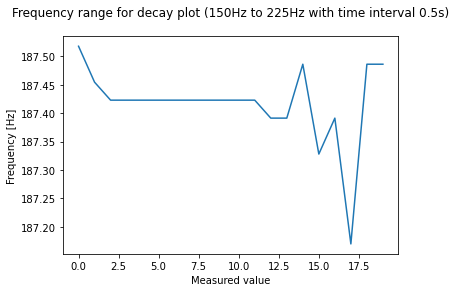

In [124]:
first_harm_amp, first_harm_freq, first_harm_time= find_decay(input_data_decay ,time_interval = 0.5,plot_graph=True)
#print(first_harm_time)

[2.46777018e+08 1.99882094e+00]


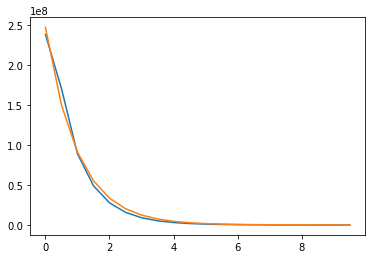

In [123]:

from scipy.optimize import curve_fit

def fit_expo(time, amplitude, gamma):
  return amplitude * (np.exp(1) ** (-((gamma/2) * time)))



initial_guess = [2.5e8, 2.0]
fit, cov = curve_fit(fit_expo,first_harm_time,first_harm_amp, p0=initial_guess, absolute_sigma=True)

amplitude, gamma = fit

print(fit)
# #plt.plot(wavelength,fit_func(wavelength,a,mu,sig,m,c))
plt.plot(first_harm_time, first_harm_amp)
plt.plot(first_harm_time, fit_expo(first_harm_time, amplitude, gamma))


